In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import string
from sklearn.neighbors import KNeighborsClassifier
import time
from sklearn import random_projection
import numpy as np
from scipy import sparse
from scipy.sparse import csr_matrix, vstack 

In [2]:
#load datasets
data = pd.read_csv("C:/Users/Professional/BigDataAnalytics/imdb/processed_data.csv")
test = pd.read_csv("C:/Users/Professional/BigDataAnalytics/imdb/processed_test.csv")

A first look at the data

In [3]:
data.head()

,id,review,sentiment
0,34006,creat realiti core question behind highli orig...,1
1,10965,dear god begin bar none best movi ever seen ca...,1
2,9471,spoiler blown away movi rent movielink bit dec...,1
3,18392,see film case grudg japanes film infinit bette...,0
4,22981,reason give kid actor play tadashi tormentor j...,1


In [4]:
test.head()

,id,review
0,33527,must see movi anyon ever went camp want film c...
1,23058,world dragon hunter graviti challeng world pla...
2,21058,watch movi think get good moment wrong real be...
3,31732,classic mani great dialog scene nobodi miss ni...
4,17285,italian french remak film name turn heat earli...


In [5]:
data.shape

(40000, 3)

In [6]:
test.shape

(10000, 2)

In [7]:
#checking for null values and the amount of null values
data.isnull().values.any()
print(data.isnull().sum()) 

id           0
review       0
sentiment    0
dtype: int64


In [8]:
#checking for null values and the amount of null values
test.isnull().values.any()
print(test.isnull().sum()) 

id        0
review    0
dtype: int64


In [9]:
#check for duplicate rows
duplicate_data = data[data.duplicated()]
print("Number of duplicate rows:", duplicate_data.shape[0])

Number of duplicate rows: 0


In [10]:
#check for duplicate rows
duplicate_test = test[test.duplicated()]
print("Number of duplicate rows:", duplicate_test.shape[0])

Number of duplicate rows: 0


In [11]:
#checking which are the unique labels
print(data['sentiment'].unique())

[1 0]


# Descriptive Statistics 

Total Counts of both sets 1    20022
0    19978
Name: sentiment, dtype: int64


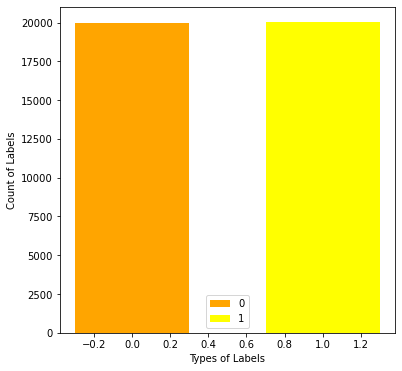

In [12]:
#Count of 0,1
count=data['sentiment'].value_counts()
print('Total Counts of both sets'.format(), count)

print("==============")
#Creating a function to plot the counts using matplotlib
def plot_counts(count_0,count_1):
    plt.rcParams['figure.figsize']=(6,6)
    plt.bar(0,count_0,width=0.6,label='0',color='Orange')
    plt.legend()
    plt.bar(1,count_1,width=0.6,label='1',color='Yellow')
    plt.legend()
    plt.ylabel('Count of Labels')
    plt.xlabel('Types of Labels')
    plt.show()
    
count_0 = data[data['sentiment']==0]
count_1 = data[data['sentiment']==1]


plot_counts(len(count_0),len(count_1))

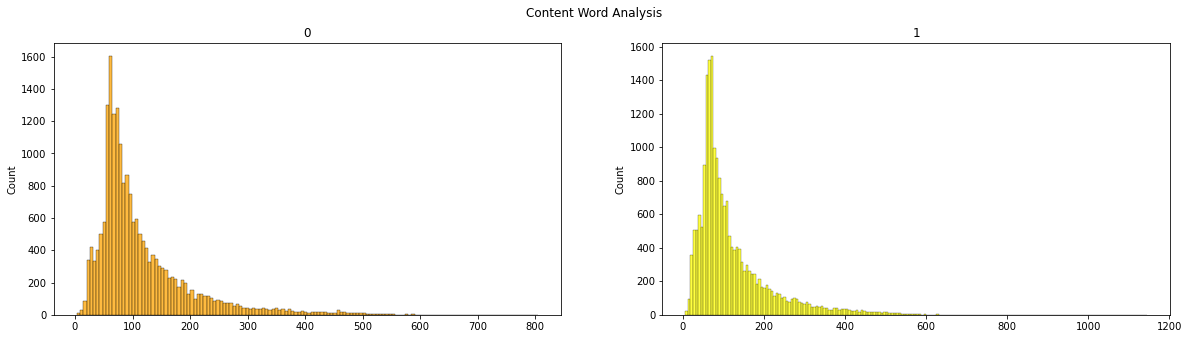

In [13]:
#Analyse the count of words in each segment for the two labels: 0,1
#Function for checking word length
def cal_len(data):
    return len(data)

#Create generic plotter with Seaborn
def plot_count(count_0_words,count_1_words,title_1,title_2,subtitle):
    fig,(ax1,ax2)=plt.subplots(1,2,figsize=(20,5))
    sns.histplot(count_0_words,ax=ax1,color='Orange')
    ax1.set_title(title_1)
    sns.histplot(count_1_words,ax=ax2,color='Yellow')
    ax2.set_title(title_2)
    fig.suptitle(subtitle)
    plt.show()    


count_0_words=[]    
for i in range(len(count_0['review'])):
    count_0_words.append(len(count_0.iloc[i]['review'].split()))
count_1_words=[]    
for i in range(len(count_1['review'])):
    count_1_words.append(len(count_1.iloc[i]['review'].split()))

# print("Entertainment:" + str(count_Entertainment_words))
# print("Technology:" + str(count_Technology_words))
# print("Business:" + str(count_Business_words))
# print("Health:" + str(count_Health_words))
plot_count(count_0_words,count_1_words,"0","1","Content Word Analysis")

# Brute Force Cosine

$\bf{Modeling}$

In [14]:
train_feat_c = data["review"].tolist()
train_lab = data["sentiment"].tolist()
test_feat_c = test["review"].tolist()
train_id = data["id"].tolist()

In [15]:
#tfidf for make the words to numerical
vectorizer = TfidfVectorizer()
train_feat = vectorizer.fit_transform(train_feat_c)
test_feat = vectorizer.transform(test_feat_c)

In [16]:
neigh = KNeighborsClassifier(n_neighbors=15, algorithm='brute', metric='cosine')
neigh.fit(train_feat,train_lab )

KNeighborsClassifier(algorithm='brute', metric='cosine', n_neighbors=15)

In [17]:
start=time.time()
BFcosine=neigh.kneighbors(test_feat, return_distance=False)
end=time.time()
print(end-start)

35.35259747505188


In [18]:
BFcos=[]
for i in range(10000):
    temp=[]
    for j in range(15):
        x=BFcosine[i,j]
        temp.append(x)
    BFcos.append(temp)
    

# LSH APPROACH


In [19]:
def data_transform(train_feat,test_feat,n):
    transformer = random_projection.GaussianRandomProjection(n_components=n)
    train_new = transformer.fit_transform(train_feat)
    train_bin=(train_new>0).astype(int)
    test_new = transformer.fit_transform(test_feat)
    test_bin=(test_new>0).astype(int)
    return train_bin, test_bin

In [20]:
def bucket_creation(train_bin):
    buckets={}
    for i in range(train_bin.shape[0]):
        fingerprint=''.join(train_bin[i].astype(str))
        if fingerprint not in buckets.keys():
            buckets[fingerprint]=[]
        buckets[fingerprint].append(i)
    return buckets

In [21]:
def lsh_knn_fit(train_feat_c,train_lab,vectorizer,buckets):
    nn={}
    for fingerprint in buckets.keys():
        index_list = buckets[fingerprint]
        bucket_train=[]
        bucket_lab=[]
        for ind in index_list:
            bucket_train.append(train_feat_c[ind])
            bucket_lab.append(train_lab[ind])
        
        bucket_train=vectorizer.transform(bucket_train)

        
        n_n =  KNeighborsClassifier(n_neighbors=15, algorithm='brute', metric='cosine').fit(bucket_train,bucket_lab)
        nn[fingerprint] = n_n
    return nn

In [22]:
def common(vec1,vec2):
    x=0
    for i in range(len(vec1)):
        if vec1[i] in vec2:
                x+=1
    return x 

In [23]:
def matches_list(top_list,BFcos):
    matches=[]
    for i in range(len(top_list)):
        m=common(top_list[i],BFcos[i])
        matches.append(m)
    return matches

In [24]:
def number_of_matches(matches):
    s=0
    for i in range(10000):
        if matches[i]>0:
            s=s+1
    return s       

In [25]:
def quering(test_bin,test_feat,buckets,nn):
    top_15=[]
    for i in range(10000):
        fingerprint=''.join(test_bin[i].astype(str))
        if fingerprint not in buckets.keys():
            buckets[fingerprint]=[]
        
        index=buckets[fingerprint]
        if len(index)<15:
            temp=index[:]
        else:
            n=nn[fingerprint].kneighbors(test_feat[i], return_distance=False)
            n=n.tolist()
            n=n[0]
            temp=[]
            for i in range(len(n)):
                ind=index[n[i]]
                temp.append(ind)
        top_15.append(temp)
    return top_15

In [26]:
K=[2,3,5,7,10,50,100]
BuildTime = []
QueryTime = []
TotalTime = []
AvgPerc = []
for k in K:
    #LSH Index Creation Time
    start=time.time()
    train_bin , test_bin = data_transform(train_feat,test_feat, k)
    buckets=bucket_creation(train_bin)
    nn =lsh_knn_fit(train_feat_c,train_lab,vectorizer,buckets)
    end=time.time()
    b=end-start
    BuildTime.append(b)
    #QueryTime
    start=time.time()
    top_15=quering(test_bin,test_feat,buckets,nn)
    end=time.time()
    q=end-start
    QueryTime.append(q)
    t=b+q
    TotalTime.append(t)
    matches=matches_list(top_15,BFcos)
    perc = ((sum(matches)/15)/10000)*100
    AvgPerc.append(perc)   

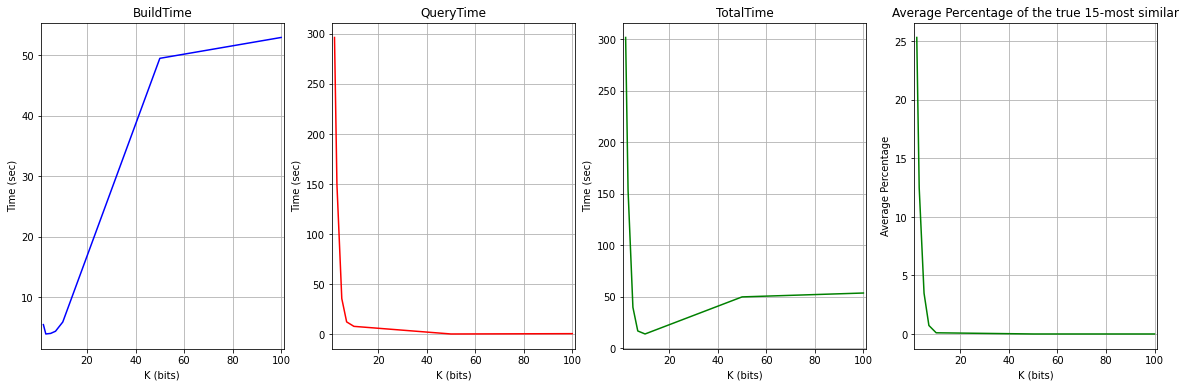

<Figure size 432x432 with 0 Axes>

In [27]:
fig = plt.figure(figsize=(20, 6))

plt.subplot(1,4,1)
plt.plot(K, BuildTime, color='b')
plt.xlim(1,K[-1]+1)
plt.grid(True)
plt.xlabel('K (bits)')
plt.ylabel('Time (sec)')
plt.title("BuildTime")

plt.subplot(1,4,2)
plt.plot(K, QueryTime, color='r')
plt.xlim(1,K[-1]+1)
plt.grid(True)
plt.xlabel('K (bits)')
plt.ylabel('Time (sec)')
plt.title("QueryTime")

plt.subplot(1,4,3)
plt.plot(K, TotalTime, color='g')
plt.xlim(1,K[-1]+1)
plt.grid(True)
plt.xlabel('K (bits)')
plt.ylabel('Time (sec)')
plt.title("TotalTime")

plt.subplot(1,4,4)
plt.plot(K, AvgPerc, color='g')
plt.xlim(1,K[-1]+1)
plt.grid(True)
plt.xlabel('K (bits)')
plt.ylabel('Average Percentage')
plt.title("Average Percentage of the true 15-most similar")

plt.show()
plt.savefig('Cosine')

In [28]:
print(AvgPerc)
print(BuildTime)
print(QueryTime)
print(TotalTime)

[25.33533333333333, 12.499333333333334, 3.4806666666666666, 0.7259999999999999, 0.10066666666666665, 0.0, 0.0]
[5.4477105140686035, 3.9015724658966064, 3.9947967529296875, 4.352674722671509, 5.881103038787842, 49.455727338790894, 52.90380835533142]
[296.2549982070923, 149.52751803398132, 35.82094097137451, 12.54545783996582, 8.091359615325928, 0.49567413330078125, 0.8118302822113037]
[301.7027087211609, 153.42909049987793, 39.8157377243042, 16.89813256263733, 13.97246265411377, 49.951401472091675, 53.715638637542725]
